# Overview:
Here, we describe the code we use to simulate a population of binaries under the influence of a population of subhalos. The primary goal of this tutorial is to teach the reader how to run Monte Carlo simulations of binaries interacting with perturbing subhalos as described in the paper. Here, the code is contained in the evol.py file, which one must run using the terminal. In this notebook, we go through blocks of the code, explaining its purpose and how it works. We strongly advise readers to read Section III of the paper before attempting to use the code.

Before we begin, it is useful to give an overview of what we are trying to do. We want to set limits on subhalo populations using a catalog of wide binaries. As discussed in the paper, this requires us to predict the present-day orbital distribution of binaries $\phi(\vec{q})$ given an initial orbital distribution $\phi_{0}(\vec{q}_{0})$, where $\vec{q} = (a,e,\psi,M)$ denotes a binary orbital state. We found

$$
\begin{aligned}
    \phi(\vec{q}) = \int d\vec{q}_0 \ S(\vec{q}|\vec{q}_0) \ \phi_0(\vec{q}_0),
\end{aligned}
$$

where $S(\vec{q}|\vec{q}_0) \ \phi_0(\vec{q}_0)$ denotes the scattering matrix. It is the probability that, from the time the binary population was assembled to the present-day, the binary's orbital state evolves from $\vec{q}_{0}$ to $\vec{q}$ due to encounters with the perturber population. 

# Initialization
## Load Perturber-Binary System
The first step is to specify our population of binaries and perturbers. In this example, we assume the perturbers are uniformly distributed in space and exhibit Maxwellian velocity profile with velocity dispersion $\sigma$, such that $\sqrt{2}\sigma = 240 \ {\rm km/s}$, and is truncated at the escape velocity $v_{\rm esc} = 533 \ {\rm km/s}$. In this case, the population of perturbers are completely specified by their individual masses $M_{p}$ and the number density $n_{p} = f_{p} \times \frac{\rho_{\rm DM}}{M_{p}}$, where $\rho_{\rm DM}$ is the local dark matter density $\rho_{DM} = 0.39 \ GeV/cm^{3}$ and $f_{p}$ is the fraction of the dark matter that is made of subhalos. 

Moreover, we assume the perturbers have a power-law density profile specified by power law index $\alpha$ and truncated at the radius $R_{p}$. I.e., 
$$ \rho(r) \propto r^{\alpha} \ \Theta(R_{p} - r) \ : \ \alpha > -3, $$
where $\Theta$ is the Heaviside theta function, which enforces the truncation of the profile. The normalization is fixed by the condition that the total mass is $M_{p}$.

A single run of the simulation computes the histogram $S(s_{i}|a_{j})$ over several bins centered at $a_{j}$. Therefore, we specify the bin centers $a_{j}$ over which we sample the binary semimajor axes. Moreover, we assume the binaries have the same velocity profile as the subhalos, as would be expected for binaries moving in the stellar halo (and an assumption that would set conservative limits for binaries living in the thick disk). Therefore, specifying the parameters for the perturber velocity profile specifies the binary velocity profile. 

The binaries evolve for $T = 10$ Gyr.

There are some other implicit assumptions that we make about the populations. But, they do not require parameterizations, so they do not require specification in this block.

In [1]:
# Initialization

## packages and functions
import timeit as timeit
import sys
import os
import numpy as np
import math as math 
from scipy.stats import maxwell
from scipy.integrate import quad, dblquad
from scipy.special import erf, hyp2f1
import matplotlib.pyplot as plt

ti = timeit.default_timer() ## starts a timer 

## input parameters
a0 = float(0.01)    # initial binary semimajor axis (pc)    # perturber mass (M_solar)
str_a0 = str.format('{0:.9f}',a0)
log_m = float(3) # perturber mass (M_solar)
str_log_m = str.format('{0:.3f}',log_m)
m = 10**log_m
log_rs = float(-1) # NFW scale radius (pc)
str_log_rs = str.format('{0:.3f}',log_rs)
rs = 10**log_rs
alpha = float(0) # power law index
str_alpha = str.format('{0:.3f}',alpha)
if alpha == -3: # point-mass limit not well-defined, but the limit exists
    alpha = -2.99999  # estimate of point-mass limit (robustness was verified)
log_f = float(0.2) # halo fraction [setting max number of time steps]
f = 10**log_f
str_log_f = str.format('{0:.3f}',log_f)

## conversion factors:
kg_g = 1E-3
Msolar_kg = 5.02785E-31 # Msolar/kg
pc_m = 3.24078E-17 # pc/m
Gyr_yr = pow(10,-9) # Gyr/yr
yr_s = 3.17098E-8 # yr/s
km_m = 1/1000 # km/m
kg_GeV = 1.78266E-27 # kg / (GeV / c**2)
m_cm = pow(10,-2) # m/cm
pc_AU = 4.84814e-6 # pc/AU
AU_pc = 206265  # AU/pc

## fixed parameters 
v0 = 240 # circular velocity (km/s) 
vesc = 533 # local escape velocity (km/s)
T = 10 # evolution time (Gyr)
rho_pdg = 0.39 # Local DM Density (GeV / cm3)
rho = 0.39 * (Msolar_kg) * (kg_GeV) * (pc_m)**(-3) * (m_cm)**(-3) #(M_sol / pc^3)

## constants
G = 4.30091e-3   # Grav Constant (pc (M_solar)^-1 (km/s)**2)

## Specify Number of Timesteps $N$
Next, we must specify the number of timesteps $N$ at which each binary experiences an encounter. Recall, that we are assuming that the binary encounters are equally-spaced in time over the 10 Gyr evolution. As we discussed in the paper, this means
$$ 
\begin{equation}
    N = {\rm int} \left [ \frac{T}{\left \langle \delta t \right \rangle} \right ], \label{eq:NfT}
\end{equation}
$$
where the $\left \langle \delta t \right \rangle$ is the (relative) velocity-averaged time between encounters $\delta t$. It is related to the scattering rate $d \mathcal{N}/dt$ via $\delta t = (d \mathcal{N}/dt)^{-1}$. The scattering rate is given by
$$
\begin{equation}
     \frac{d \mathcal{N} }{dt} = f_{p} \left ( \frac{\rho_{DM}}{M_{p}} \right ) \times \pi p_{{\rm max}}^{2} \times v_{p},
\end{equation}
$$
where $v_{p}$ denotes the velocity of the perturber *relative* to the binary and $p_{\rm max}$ is the maximum impact parameter sampled in the simulations. One can choose $p_{\rm max}$ large enough so that the results of the simulation become robust to the choice. However, as seen above, the number of encounters goes as $p_{\rm max}^{2}$, quickly making our simulations very inefficient. Therefore, we decided to take it to be the impact parameter at which the expected cumulative set of tidal interactions over time $T$ between the subhalo and the binary could, at maximum, inject 1\% of the binary's initial binding energy, which gives robust results. Readers interested in how we did this should read the pdf in supplement/_____.pdf. However, we state that we assumed a simplified geometry for the perturber encounters: circular orbits and perpendicular orientation of the binary and the perturber velocity. 

Therefore, there are two components to calculating $N$: $p_{\rm max}$ and $\left \langle \delta t \right \rangle$

### Calculating $p_{\rm max}$
Following the discussion in the pdf, we arrive at the following expression
$$ 
\begin{aligned}
    p_{max} = a \sqrt{1 + 2 \Delta \bar{\varepsilon}^{-1} (1 + \sqrt{1+ \Delta \bar{\varepsilon}} )},
\end{aligned}
$$
where $\Delta \bar{\varepsilon}$ denotes a geometric factor times the fraction of the binary's initial binding energy injected by a perturber encounter. The encounter we consider is that which $p_{\rm max}$, circular orbit,  and perpendicular orientation of the binary and perturber velocity. Specifically, one finds
$$
\begin{aligned}
    \Delta \bar{\varepsilon} = \frac{E}{\pi \times f_{p} \times \rho_{DM} \times T \times M_p \times \bar{C}} \times \Delta \varepsilon,
\end{aligned}
$$
where $\bar{\mathcal{C}} = (2 G M_{p})^{2} \times \langle v^{-1} \rangle / 2 $

This can be seen in the block below for the definition of $p_{\rm max}$. As stated, we find $p_{\rm max}$ by requiring $\Delta \varepsilon = 1\%. As discussed in the supplementary document, larger impact parameters only have weaker encounters.

Given our initialization of perturber and binary parameters, all we need to do is compute $\langle v_{p} \rangle$.



### Calculating $\langle v_{p}^{-1} \rangle$
We calculate $\langle v_{p}^{-1} \rangle$ by first finding the distribution function of the relative perturber velocities. We find this distribution function in the supplementary pdf. Though we have an expression, integrals of this distribution possess no analytic expression. Therefore, we perform the average using the block below.
$$
\begin{equation}
    f_{V}(v) \propto v^{2} \ \exp \left (-\frac{v^{2}}{4 \sigma^{2}} \right ) \ \xi(v), v \in [0, 2v_{esc}),
\end{equation}
$$
where $\xi(v)$ denotes a correction due to the truncation of the Maxwell-Boltzmann distributions forming the relative velocity distribution. We find 
$$ \xi(v) = \int_{-1}^{1} \cos \theta \ \int_{0}^{v_{\theta}(\cos \theta)} \ dv' \ v'^{2} \ \exp \left [ -\frac{v'^{2}}{\sigma^{2}} \right ], $$
where 
$$ v_{\theta}(\cos \theta) = -\frac{v}{2} \cos \theta + \sqrt{\left ( \frac{v}{2} \right ) ^{2} \cos^{2} \theta + \left [ v_{esc}^{2} - \left ( \frac{v}{2} \right ) ^{2} \right ] } $$

In the code, we write define the following functions to semianalytically compute the average $\langle v_{p}^{-1} \rangle$
* $v_{\theta}$
* $f_{V}(v,\sigma,v_{esc}\rightarrow \infty) \rightarrow f_{V, no vesc}$ (relative velocity distribution for untruncated Maxwell velocity profiles)
* $\xi(v) \rightarrow \frac{df_{V}}{d\cos \theta}|_{\rm eff}$ ($\xi(v)$ written in terms of a $d\cos \theta$ integral)
* $\langle v^{-1} \rangle$

 *   ```python
    def v_theta_(cos_theta,v,vesc):
        return -v*cos_theta + np.sqrt(v*v*cos_theta*cos_theta + (vesc*vesc - v*v))
    ```

 *   ```python
    def fv_no_vesc_(v, sigma):
        return v*v*np.exp(-v*v / 4 / sigma / sigma)
    ```
    
 *   ```python
    def dfv_dcos_theta_eff_(v_theta,sigma):
        return (1/4) * (-2 * v_theta * np.exp( - v_theta * v_theta / sigma / sigma ) 
                     + np.sqrt(np.pi) * sigma * erf(v_theta / sigma) ) 
    ```
 *   ```python
    def inv_v_avg_(sigma,vesc,normalization):
        v_avg_eff = ( dblquad(lambda cos_theta, v: 
                                         fv_no_vesc_(v, sigma) * dfv_dcos_theta_eff_(v_theta_(cos_theta,v/2,vesc),sigma) / v, 0, 2*vesc, 
                                         lambda v: 0, lambda v: 1)[0] )
        return v_avg_eff / normalization
    ```

In [2]:
## set up maximum impact parameter and time steps

### Compute the average inverse velocity for the truncated velocity profile

def v_theta_(cos_theta,v,vesc):
    return -v*cos_theta + np.sqrt(v*v*cos_theta*cos_theta + (vesc*vesc - v*v))

def fv_no_vesc_(v, sigma):
    return v*v*np.exp(-v*v / 4 / sigma / sigma)

def dfv_dcos_theta_eff_(v_theta,sigma):
    return (1/4) * (-2 * v_theta * np.exp( - v_theta * v_theta / sigma / sigma ) 
                 + np.sqrt(np.pi) * sigma * erf(v_theta / sigma) ) 

def inv_v_avg_(sigma,vesc,normalization):
    v_avg_eff = ( dblquad(lambda cos_theta, v: 
                                     fv_no_vesc_(v, sigma) * dfv_dcos_theta_eff_(v_theta_(cos_theta,v/2,vesc),sigma) / v, 0, 2*vesc, 
                                     lambda v: 0, lambda v: 1)[0] )
    return v_avg_eff / normalization

sigma = v0/math.sqrt(2)/math.sqrt(2)
normalization = ( dblquad(lambda cos_theta, v: 
                                     fv_no_vesc_(v, sigma) * dfv_dcos_theta_eff_(v_theta_(cos_theta,v/2,vesc),sigma), 0, 2*vesc, 
                                     lambda v: 0, lambda v: 1)[0] )
inv_v_avg = inv_v_avg_(sigma,vesc,normalization)

In [3]:
'''
Example: Comparing the semianalytic computation to brute-force sampling

Interestingly, we can estimate the distribution very well with untruncated Maxwell distributions. However, we can see our description is accurate when we set v0 \sim vesc$. 

'''

N_enc = int(1e7)
def v_rel_sampler(vc,vesc,N_enc):
    ## relative velocity sampler for truncated MB distributions
    ### note, divide by sqrt(2) because maxwell.rvs automatically has a 2 in denominator of exponential
    ### divide by sqrt(2) one more time since v_c is the MACHO-MACHO relative velocity dispersion 
    ### NOT the velocity dispersion of stars and halos(01/16/2022)
    sigma_v = vc / math.sqrt(2) / math.sqrt(2)
    v1_sample = maxwell.rvs(loc = 0, scale = sigma_v, size = N_enc)
    N_v = len(v1_sample[v1_sample>vesc])
    while N_v > 0:
        v1_sample[v1_sample>vesc] = maxwell.rvs(loc = 0, scale = sigma_v, size = N_v)
        N_v = len(v1_sample[v1_sample>vesc])

    v2_sample = maxwell.rvs(loc = 0, scale = sigma_v, size = N_enc)
    N_v = len(v2_sample[v2_sample>vesc])
    while N_v > 0:
        v2_sample[v2_sample>vesc] = maxwell.rvs(loc = 0, scale = sigma_v, size = N_v)
        N_v = len(v2_sample[v2_sample>vesc])

    phi1_sample = np.random.random(size = N_enc) * 2 * np.pi
    phi2_sample = np.random.random(size = N_enc) * 2 * np.pi
    theta1_sample = np.arccos(2 * ( np.random.random(size = N_enc) ) - np.ones(N_enc))
    theta2_sample = np.arccos(2 * ( np.random.random(size = N_enc) ) - np.ones(N_enc))

    vx1_sample = v1_sample * np.sin(theta1_sample) * np.cos(phi1_sample)
    vx2_sample = v2_sample * np.sin(theta2_sample) * np.cos(phi2_sample)
    vy1_sample = v1_sample * np.sin(theta1_sample) * np.sin(phi1_sample)
    vy2_sample = v2_sample * np.sin(theta2_sample) * np.sin(phi2_sample)
    vz1_sample = v1_sample * np.cos(theta1_sample)
    vz2_sample = v2_sample * np.cos(theta2_sample)

    vx_rel_sample = vx1_sample - vx2_sample
    vy_rel_sample = vy1_sample - vy2_sample
    vz_rel_sample = vz1_sample - vz2_sample

    v_rel_sample = np.sqrt(vx_rel_sample**2 + vy_rel_sample**2 + vz_rel_sample**2)
    return v_rel_sample

# ---
v0 = 240
vesc = 533

v_sample = v_rel_sampler(v0,vesc,N_enc)

sigma = v0/math.sqrt(2)/math.sqrt(2)
normalization = ( dblquad(lambda cos_theta, v: 
                                     fv_no_vesc_(v, sigma) * dfv_dcos_theta_eff_(v_theta_(cos_theta,v/2,vesc),sigma), 0, 2*vesc, 
                                     lambda v: 0, lambda v: 1)[0] )

# ---

# Semianalytic computation of the relative velocity profile 
bins = np.linspace(0,1200,100)
delta_v = np.diff(bins)
v_mid = 0.5 * (bins[1:] + bins[:-1])
fv = np.array([quad(lambda cos_theta: fv_no_vesc_(v, sigma) * dfv_dcos_theta_eff_(v_theta_(cos_theta,v/2,vesc),sigma),0,1)[0]
      for v in v_mid]) / normalization

/tmp/ipykernel_503/1307343812.py:6: RuntimeWarning: invalid value encountered in sqrt
  return -v*cos_theta + np.sqrt(v*v*cos_theta*cos_theta + (vesc*vesc - v*v))
/tmp/ipykernel_503/3504101740.py:63: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  fv = np.array([quad(lambda cos_theta: fv_no_vesc_(v, sigma) * dfv_dcos_theta_eff_(v_theta_(cos_theta,v/2,vesc),sigma),0,1)[0]


(0.0, 1200.0)

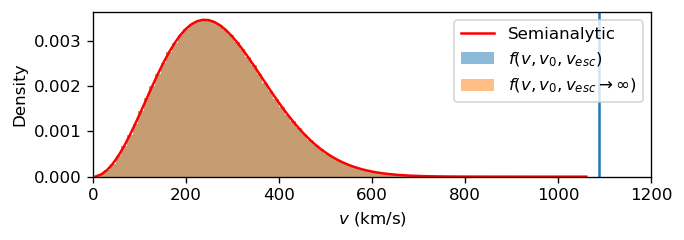

In [4]:
fig = plt.figure(figsize=(6,4), dpi= 120)
ax = fig.add_subplot(211)
counts, bins, _ = ax.hist(v_sample, bins = np.linspace(0,1200,100),density = True, alpha = 0.5)
counts_approx, bins, _ = ax.hist(maxwell.rvs(loc = 0, scale = v0 / np.sqrt(2), size = N_enc),bins = np.linspace(0,1200,100),density = True, alpha = 0.5)
ax.plot(v_mid,fv,c = 'r')
ax.set_xlabel("$v$ (km/s)")
ax.set_ylabel("Density")
ax.legend(['Semianalytic','$f(v,v_{0},v_{esc})$','$f(v,v_{0},v_{esc} \\rightarrow \\infty)$'])
ax.axvline(x = 2*544)
ax.set_xlim([0,1200])

### Plots of $p_{\rm max}$
Now that we have computed $\langle v^{-1} \rangle$, we can calculate $p_{\rm max}$ using the previous block of code for $\langle v^{-1} \rangle$ and
$$ 
\begin{aligned}
    p_{max} = a \sqrt{1 + 2 \Delta \bar{\varepsilon}^{-1} (1 + \sqrt{1+ \Delta \bar{\varepsilon}} )},
\end{aligned}
$$
Looking above $p_{max}$ depends on many of the parameters we have introduced so far. We want to choose the maximum possible $p_{\rm max}$. As we only measure binaries with separations up to $1$ pc, we set $a = 1$ pc. Similarly, we get the maximum $p_{max}$ for $f_{p} = 1$ and $T = 10$ Gyr. We take the binary mass $M = 1 \ M_{\odot}$ for simplicity. The last parameter that can modify it is the perturber mass $M_{p}$, which we take to be the mass of the perturbers that we are simulating. In this case, $M_{p} = 10^{3} \ M_{\odot}$.

Given these choices, let's see how $p_{\rm max}$ depends on $M_{p}$ and our choice of the fractional energy injection $\Delta \varepsilon$.

In [5]:
## set up maximum impact parameter and time steps

### Compute the average inverse velocity for the truncated velocity profile

def v_theta_(cos_theta,v,vesc):
    return -v*cos_theta + np.sqrt(v*v*cos_theta*cos_theta + (vesc*vesc - v*v))

def fv_no_vesc_(v, sigma):
    return v*v*np.exp(-v*v / 4 / sigma / sigma)

def dfv_dcos_theta_eff_(v_theta,sigma):
    return (1/4) * (-2 * v_theta * np.exp( - v_theta * v_theta / sigma / sigma ) 
                 + np.sqrt(np.pi) * sigma * erf(v_theta / sigma) ) 

def inv_v_avg_(sigma,vesc,normalization):
    v_avg_eff = ( dblquad(lambda cos_theta, v: 
                                     fv_no_vesc_(v, sigma) * dfv_dcos_theta_eff_(v_theta_(cos_theta,v/2,vesc),sigma) / v, 0, 2*vesc, 
                                     lambda v: 0, lambda v: 1)[0] )
    return v_avg_eff / normalization

sigma = v0/math.sqrt(2)/math.sqrt(2)
normalization = ( dblquad(lambda cos_theta, v: 
                                     fv_no_vesc_(v, sigma) * dfv_dcos_theta_eff_(v_theta_(cos_theta,v/2,vesc),sigma), 0, 2*vesc, 
                                     lambda v: 0, lambda v: 1)[0] )
inv_v_avg = inv_v_avg_(sigma,vesc,normalization)

### max impact parameter when the fractional energy injection falls below energy_fraction
def p_max_(a,m,M,inv_v_avg,f,energy_fraction): 
    bar_C = 2*G*m * 2*G*m / 2 * inv_v_avg
    E = G * M / 2 / a
    inv_factor = np.pi * (f * rho * T / m) * bar_C / E
    bar_delta_Eps_val = inv_factor**(-1) * energy_fraction
    #if m >= 10:
    #    return a * np.sqrt(1 + 2 * bar_delta_Eps_val**(-1) * (1 + np.sqrt(1 + bar_delta_Eps_val))) # pc
    #else:
    #    return (m/10)**(1/2) * a * np.sqrt(1 + 2 * bar_delta_Eps_val**(-1) * (1 + np.sqrt(1 + bar_delta_Eps_val))) # pc
    return a * np.sqrt(1 + 2 * bar_delta_Eps_val**(-1) * (1 + np.sqrt(1 + bar_delta_Eps_val))) # pc

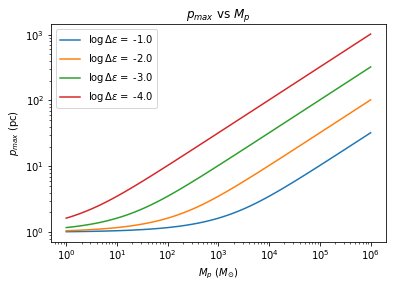

In [6]:
### plot of our choice of pmax vs m for specified parameters and varying threshold fractional energy 
mlist = np.logspace(0,6,100)
log_delta_epsilon_list = np.linspace(-1,-4,4)

for log_delta_epsilon in log_delta_epsilon_list:
    energy_fraction = 10**log_delta_epsilon
    plt.loglog(mlist, [p_max_(1,m,1,inv_v_avg,1,energy_fraction) for m in mlist], label = ('$\\log \\Delta \\varepsilon =$ ' + str(log_delta_epsilon)))
    plt.xlabel('$M_{p}$ $(M_{\odot})$')
    plt.ylabel('$p_{max}$ (pc)')
    plt.title('$p_{max}$ vs $M_{p}$')
    plt.legend()

### Compute Number of Timesteps $N$ from $\langle \delta t \rangle$
With $p_{max}$, We are now ready to compute the number of timesteps. We do this by computing $\langle \delta t \rangle$ via
$$ \langle \delta t  \rangle = \frac{M_{p}}{f_{p} \times \rho_{DM} \times \pi p_{max}^{2}} \times \left \langle \frac{1}{v_{p}} \right \rangle $$
and
$$ 
\begin{equation}
    N = {\rm int} \left [ \frac{T}{\left \langle \delta t \right \rangle} \right ]. \label{eq:NfT}
\end{equation}
$$

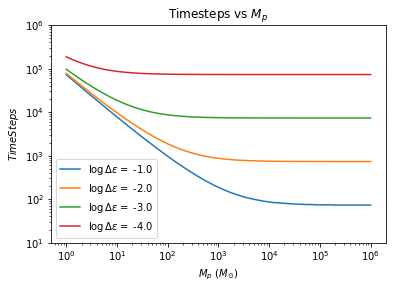

In [7]:
### load number of time steps needed to evolve for the specified evolution time
def delta_t_(m,inv_v_avg,f,R):    # length of time step in Gyr
    delta_t_val = m / (f * rho * np.pi * R**2) * inv_v_avg
    delta_t_val_Gyr = delta_t_val * ( (km_m) / (pc_m) ) * ( (Gyr_yr) * (yr_s) ) 
    return delta_t_val_Gyr  # Gyr

### plot of our choice of pmax vs m for specified parameters and varying threshold fractional energy 
mlist = np.logspace(0,6,100)
log_delta_epsilon_list = np.linspace(-1,-4,4)

#plt.loglog(mlist,[int(T / delta_t(m,v0,1,10)) for m in mlist])
for log_delta_epsilon in log_delta_epsilon_list:
    energy_fraction = 10**log_delta_epsilon
    N_list =  [int(T / delta_t_(m,inv_v_avg,1,p_max_(1,m,1,inv_v_avg,1,energy_fraction))) for m in mlist]
    plt.loglog(mlist, N_list, label = ('$\\log \\Delta \\varepsilon =$ ' + str(log_delta_epsilon)))
    plt.xlabel('$M_{p}$ $(M_{\odot})$')
    plt.ylabel('$Time Steps$')
    plt.title('Timesteps vs $M_{p}$')
    plt.ylim([10**1,10**6])
    plt.legend()
    
log_eps = float(-2)   # threshold fractional energy injection defining p_max
energy_fraction = 10**log_eps
str_log_eps = str.format('{0:.2f}',log_eps)
p_max = p_max_(1,m,1,inv_v_avg,1,energy_fraction) # p_max value (f=1 for efficiency, M =1 standard stable)
delta_t = delta_t_(m,inv_v_avg,f,p_max)    # delta_t value
N = int(T / delta_t)    # number of time steps

In [8]:
## set up maximum impact parameter and time steps

### Compute the average inverse velocity for the truncated velocity profile

def v_theta_(cos_theta,v,vesc):
    return -v*cos_theta + np.sqrt(v*v*cos_theta*cos_theta + (vesc*vesc - v*v))

def fv_no_vesc_(v, sigma):
    return v*v*np.exp(-v*v / 4 / sigma / sigma)

def dfv_dcos_theta_eff_(v_theta,sigma):
    return (1/4) * (-2 * v_theta * np.exp( - v_theta * v_theta / sigma / sigma ) 
                 + np.sqrt(np.pi) * sigma * erf(v_theta / sigma) ) 

def inv_v_avg_(sigma,vesc,normalization):
    v_avg_eff = ( dblquad(lambda cos_theta, v: 
                                     fv_no_vesc_(v, sigma) * dfv_dcos_theta_eff_(v_theta_(cos_theta,v/2,vesc),sigma) / v, 0, 2*vesc, 
                                     lambda v: 0, lambda v: 1)[0] )
    return v_avg_eff / normalization

sigma = v0/math.sqrt(2)/math.sqrt(2)
normalization = ( dblquad(lambda cos_theta, v: 
                                     fv_no_vesc_(v, sigma) * dfv_dcos_theta_eff_(v_theta_(cos_theta,v/2,vesc),sigma), 0, 2*vesc, 
                                     lambda v: 0, lambda v: 1)[0] )
inv_v_avg = inv_v_avg_(sigma,vesc,normalization)

### max impact parameter when the fractional energy injection falls below energy_fraction
def p_max_(a,m,M,inv_v_avg,f,energy_fraction): 
    bar_C = 2*G*m * 2*G*m / 2 * inv_v_avg
    E = G * M / 2 / a
    inv_factor = np.pi * (f * rho * T / m) * bar_C / E
    bar_delta_Eps_val = inv_factor**(-1) * energy_fraction
    #if m >= 10:
    #    return a * np.sqrt(1 + 2 * bar_delta_Eps_val**(-1) * (1 + np.sqrt(1 + bar_delta_Eps_val))) # pc
    #else:
    #    return (m/10)**(1/2) * a * np.sqrt(1 + 2 * bar_delta_Eps_val**(-1) * (1 + np.sqrt(1 + bar_delta_Eps_val))) # pc
    return a * np.sqrt(1 + 2 * bar_delta_Eps_val**(-1) * (1 + np.sqrt(1 + bar_delta_Eps_val))) # pc


### load number of time steps needed to evolve for the specified evolution time
def delta_t_(m,inv_v_avg,f,R):    # length of time step in Gyr
    delta_t_val = m / (f * rho * np.pi * R**2) * inv_v_avg
    delta_t_val_Gyr = delta_t_val * ( (km_m) / (pc_m) ) * ( (Gyr_yr) * (yr_s) ) 
    return delta_t_val_Gyr  # Gyr

log_eps = float(-2)   # threshold fractional energy injection defining p_max
energy_fraction = 10**log_eps
str_log_eps = str.format('{0:.2f}',log_eps)
p_max = p_max_(1,m,1,inv_v_avg,1,energy_fraction) # p_max value (f=1 for efficiency, M =1 standard stable)
delta_t = delta_t_(m,inv_v_avg,f,p_max)    # delta_t value
N = int(T / delta_t)    # number of time steps

## Load the Encounters
### PDFs
With the number of timesteps $N$ specified, we now specify the amount of binaries $K$ that we wish to simulate. The number of total encounters in this simulation is then $N_{enc} = N \times K$.

Now, we generate all $N_{enc}$ encounters by sampling $N_{enc}$ encounter parameters $\vec{x} = (p,\theta,\phi,\gamma,v_{p})$ from their respective distributions. We sample the impact parameter $p$ from a uniform distribution over the disk of radius $p_{max}$. Whereas, $\theta$ and $\phi$ are drawn from the uniform distribution over solid angles, $\gamma$ is drawn from a uniform distribution from $0$ to $2\pi$, $v_{p}$ is drawn from the relative velocity distribution obtained by sampling over two identical Maxwell-Boltzmann velocity distributions with dispersions given by $\sigma = v_{c}/2$, truncated at the escape velocity $v_{esc}$. I.e., we sample over the following PDFs:
\begin{equation}
    \begin{matrix}
    f_{P}(p) = \frac{2p}{p_{max}^2}, & p \in [0,p_{max}),\\ 
    f_{\Theta}(\theta) = \frac{1}{2}\sin(\theta), & \theta \in [0,\pi),\\ 
    f_{\Phi}(\phi) = \frac{1}{2\pi}, & \phi \in [0,2 \pi), \\
    f_{\Gamma}(\gamma) = \frac{1}{2\pi}, & \gamma \in [0,2 \pi) \\
    f_{V}(v) \propto v^{2} \ \exp \left (-\frac{v^{2}}{v_{c}^{2}} \right ) \ \xi(v), & v \in [0,2v_{esc}),
\end{matrix}
\end{equation}
where $\xi(v)$ denotes the correction due to the truncation of the Maxwell-Boltzmann distributions forming the relative velocity distribution.

### Sampling
In practice, we sample the encounter parameters using the uniform distribution from $[0,1)$ since it is well-optimized in numpy. I.e.,

1. The PDF for the impact parameter $p$ will go as the cross section. That is, if encounters are expected to be uniformly distributed along a disk, we have the probability of having an encounter between $p$ and $p+dp$ is $2 p \ dp$. Suppose the maximum impact parameter is $p=1$. This implies that the PDF for $p^2$ is uniform from $[0,1)$. Thus, we can generate $p$-samples from the simpler $p^2$ samples by taking the square-root. That is, using capital letters to denoter random variables
$$ P_{1} = \sqrt{P_{1}^{2}} = \sqrt{U([0,1))}$$
   By letting the disk have radius $R$, we need only multiply by $R$
   $$ P = \sqrt{P^{2}} = R \times \sqrt{U([0,1))} $$
   
   For comparison, the PDF of this distribution is
   $$ f_{P}(p) = \frac{2p}{R^2} \ \ \ : \ \ \ p \in [0,R)$$
   
2. The PDF for $\cos \theta$ is uniform from $[-1,1)$. So
$$ \begin{aligned} 
& \cos \Theta = U([-1,1)) = 2U([0,1)) - 1 \\
& \implies \Theta = \cos^{-1}[2U([0,1)) - 1]
\end{aligned} $$
    The PDF of this distribution is
   $$ f_{\Theta}(\theta) = \frac{1}{2}\sin(\theta) \ \ \ : \ \ \ \theta \in [0,\pi)$$

3. The PDF for $\phi$ is uniform from $[0,2\pi)$. So,
$$ \Phi = U([0,2 \pi)) = 2 \pi \times U([0,1)) $$
    The PDF for the distribution is 
    $$ f_{\Phi}(\phi) = \frac{1}{2\pi}  \ \ \ : \ \ \ \phi \in [0,2 \pi)$$

4. Note, we load relative velocities by randomly sampling the velocities of the binaries and subhalos relative to the galactocentric reference frame. To sample the velocity of each object from the Maxwellian distributions described above, we load the *maxwell* object and use the built-in *.rvs* function that randomly samples values from the distribution. The PDF for each $v$ is Maxwellian centered at $0$ and having velocity dispersion $\sigma = v_{0}/2 \ km/s$. I.e., 
$$\begin{aligned}
f_{V}(v) \ dv & = \left (\frac{1}{2 \pi \sigma^{2}} \right )^{3/2} \ 4 \pi v^{2} \ e^{-\left (\frac{v^{2}}{2\sigma^{2}} \right )} \\
& = \sqrt{2/\pi} \ x^{2} \exp^{-x^{2}/2} / \sigma \ \ \ : \ \ \ x = v/\sigma 
\end{aligned}$$
This takes the exact form of the PDF used in the *scipy.stats.maxwell* object. Therefore, instead of trying to sample these values from the uniform distribution, we load the *maxwell* object and use the built-in *.rvs* function that randomly samples values from the distribution.

### Loading Times of Encounter
Beyond the encounter parameters, we also sample a quantity that we have not defined so far. In between encounters, binaries evolve unperturbed. That is, their eccentric anomalies evolve according to Kepler's Equation:
$$
\begin{equation} \label{eq:time}
    t = \frac{P(a)}{2 \pi} \left [ \psi - e \sin \psi \right ],
\end{equation}
$$
where $P= a^{3/2} \sqrt{4 \pi^{2} / GM}$ denotes the period of the binary. As we evolve each binary forward in time, we must keep track of its changing period after every encounter in order to apply the above equation. In order to avoid having to evolve Kepler's equation for each individual binary due to their different semimajor axes and masses, we can solve Kepler's equation in terms of the effective time $\tau \equiv t / P$, which we discuss further in the next block. For now, we just say that we sample a value of $\tau$ over a uniform distribution from 0 to 1 for each binary. This is because we expect that the timing of encounters with subhalos is uncorrelated with the orbits of the binaries. Moreover, we sample values of $\tau$ for each binary and timestep for reasons that we explain in a future block, leading to $N_{enc}$ $\tau$-values.



In [9]:
# load samples
## parameters
log_K = float(3)  # v0.3: number of binaries fixed
str_log_K = str.format('{0:.2f}',log_K)
K = int(10**log_K)  
N_enc = int(N*K)   # v0.3: number of encounters calculated
R = p_max   # maximum impact parameter (pc)

#log_N_enc_approx = str.format('{0:.2f}',log_N_enc_approx)
#str_log_N_enc = str.format('{0:.2f}',log_N_enc_approx)
#N_enc_approx = int(10**log_N_enc_approx)   # number of samples
#N_enc = int(N_enc_approx / N) * N
#R = p_max   # maximum impact parameter (pc)
#K = int(N_enc / N) # number of binaries

# ------------------------------------------------------
## generate encounter samples

def v_rel_sampler(vc,vesc,N_enc):
    ## relative velocity sampler for truncated MB distributions
    ### note, divide by sqrt(2) because maxwell.rvs automatically has a 2 in denominator of exponential
    ### divide by sqrt(2) one more time since v_c is the MACHO-MACHO relative velocity dispersion 
    ### NOT the velocity dispersion of stars and halos(01/16/2022)
    sigma_v = vc / math.sqrt(2) / math.sqrt(2)
    v1_sample = maxwell.rvs(loc = 0, scale = sigma_v, size = N_enc)
    N_v = len(v1_sample[v1_sample>vesc])
    while N_v > 0:
        v1_sample[v1_sample>vesc] = maxwell.rvs(loc = 0, scale = sigma_v, size = N_v)
        N_v = len(v1_sample[v1_sample>vesc])

    v2_sample = maxwell.rvs(loc = 0, scale = sigma_v, size = N_enc)
    N_v = len(v2_sample[v2_sample>vesc])
    while N_v > 0:
        v2_sample[v2_sample>vesc] = maxwell.rvs(loc = 0, scale = sigma_v, size = N_v)
        N_v = len(v2_sample[v2_sample>vesc])

    phi1_sample = np.random.random(size = N_enc) * 2 * np.pi
    phi2_sample = np.random.random(size = N_enc) * 2 * np.pi
    theta1_sample = np.arccos(2 * ( np.random.random(size = N_enc) ) - np.ones(N_enc))
    theta2_sample = np.arccos(2 * ( np.random.random(size = N_enc) ) - np.ones(N_enc))

    vx1_sample = v1_sample * np.sin(theta1_sample) * np.cos(phi1_sample)
    vx2_sample = v2_sample * np.sin(theta2_sample) * np.cos(phi2_sample)
    vy1_sample = v1_sample * np.sin(theta1_sample) * np.sin(phi1_sample)
    vy2_sample = v2_sample * np.sin(theta2_sample) * np.sin(phi2_sample)
    vz1_sample = v1_sample * np.cos(theta1_sample)
    vz2_sample = v2_sample * np.cos(theta2_sample)

    vx_rel_sample = vx1_sample - vx2_sample
    vy_rel_sample = vy1_sample - vy2_sample
    vz_rel_sample = vz1_sample - vz2_sample

    v_rel_sample = np.sqrt(vx_rel_sample**2 + vy_rel_sample**2 + vz_rel_sample**2)
    return v_rel_sample
    
p_sample = np.sqrt(np.random.random(size = N_enc)) * R     # PDF: 2p
theta_sample = np.arccos(2 * ( np.random.random(size = N_enc) ) - np.ones(N_enc))   # PDF: sin \theta / 2
phi_sample = np.random.random(size = N_enc) * 2 * np.pi    # PDF: Uniform [0,2\pi)
gamma_sample = np.random.random(size = N_enc) * 2 * np.pi    # PDF: Uniform [0,2\pi)
v_sample = v_rel_sampler(v0,vesc,N_enc)    # PDF: Maxwellian with velocity dispersion v0 [0,\infty)
tau_rand = np.random.random(size = N_enc) # PDF for effective observation time

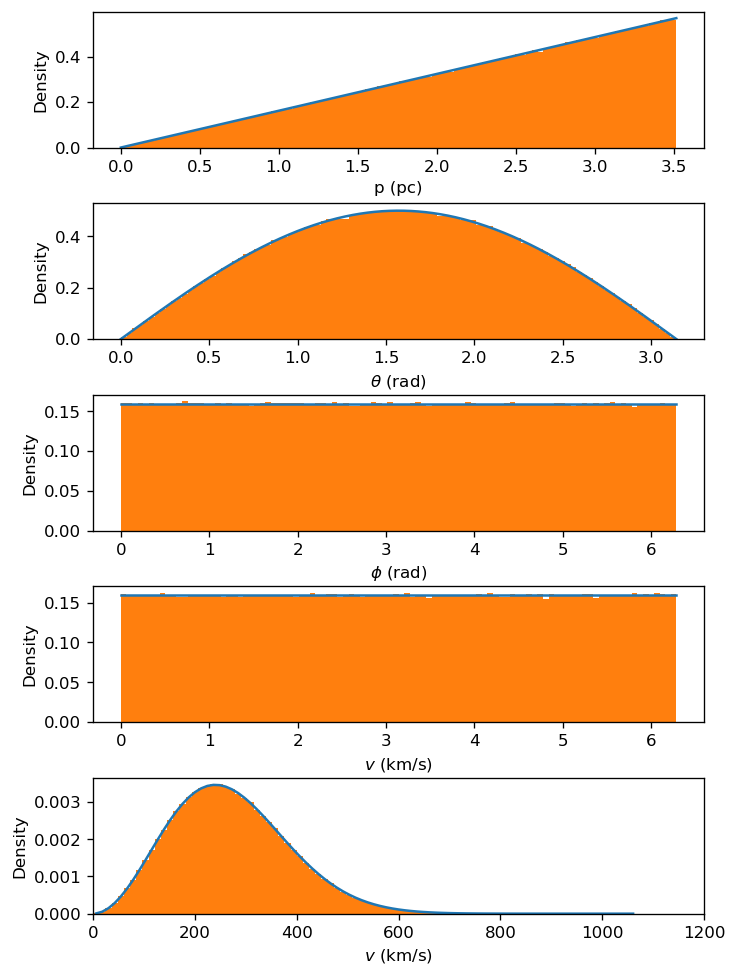

In [10]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rcParams
from matplotlib.colors import Normalize
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
from matplotlib import ticker
from matplotlib import colors

def f_p(p,R):
    return 2*p / R**2

def f_theta(theta):
    return np.sin(theta) / 2

def f_phi(phi_list):
    return 1 / 2 / np.pi * np.ones(len(phi_list))

def f_gamma(gamma):
    return 1 / 2 / np.pi * np.ones(len(gamma))

p_list = np.linspace(0,R,1000)
theta_list = np.linspace(0,np.pi,1000)
phi_list = np.linspace(0,2*np.pi,1000)
gamma_list = np.linspace(0,2*np.pi,1000)

fig = plt.figure(figsize=(6, 8), dpi= 120)
ax = fig.add_subplot(511)
ax.plot(p_list, f_p(p_list,R))
ax.hist(p_sample,100,density = True)
plt.xlabel("p (pc)")
plt.ylabel("Density")

ax = fig.add_subplot(512)
ax.plot(theta_list, f_theta(theta_list))
ax.hist(theta_sample,100,density = True)
plt.xlabel("$\\theta$ (rad)")
plt.ylabel("Density")

ax = fig.add_subplot(513)
ax.plot(phi_list, f_phi(phi_list))
ax.hist(phi_sample,100,density = True)
plt.xlabel("$\\phi$ (rad)")
plt.ylabel("Density")

ax = fig.add_subplot(514)
ax.plot(gamma_list, f_gamma(gamma_list))
ax.hist(gamma_sample,100,density = True)
plt.xlabel("$v$ (km/s)")
plt.ylabel("Density")

ax = fig.add_subplot(515)
ax.plot(v_mid,fv)
ax.hist(v_sample,bins = np.linspace(0,1200,100),density = True)
plt.xlabel("$v$ (km/s)")
plt.ylabel("Density")
ax.set_xlim([0,1200])

fig.tight_layout(pad = 0.2)

## Solving Kepler's Equation for Every Binary
In between encounters, binaries evolve from one eccentric anomaly $\psi_{i}$ to another $\psi_{f}$ after some time $\delta t$, determined above. The problem is to solve Kepler's equation for $\psi_{f}$ given $\delta t$ and $\psi_{i}$. We prefer to accomplish this in a way that is independent of the binary orbital period, so we will accomplish this with the effective time $\tau$.

In practice, we calculate $\psi(t)$ by using a matrix giving the orbital times $t_{mn}$ (from 0 to $P$) corresponding to specific values of the eccentric anomaly $\psi_{m}$ and eccentricity $e_{n}$. We find the eccentricity $e_{n}$ closest to the binary's eccentricity $e$ and search through column $n$ to find the orbital time $\bar{t}_{mn}$ closest to the specified orbital time $t$. We identify the row's corresponding phase $\psi_{m}$ with the true phase $\psi(t)$. In this way, this method requires us to generate a different matrices for binaries with different periods. By, instead, formulating this in terms of the effective time $\tau$, a single matrix of values $\tau_{mn}$ (from 0 to 1) can then be used to calculate $\psi(t)$. For our Monte Carlo simulations, we construct the matrix by calculating effective orbital times in a $10^{4} \times 10^{4}$ matrix for values of eccentric anomaly evenly distributed between $0$ and $2\pi$ and values of eccentricity evenly distributed between $0$ and $1$. 

This matrix is loaded below. The matrix was made using the *tau_mat_generator.ipynb* file.

In [11]:
# Load tau(psi,e) matrix

## find tau corresponding to eccentric anomaly and eccentricity
def find_nearest_(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return idx-1
    else:
        return idx
    
Nres = 10000
psi_discrete = np.linspace(0,2*np.pi,Nres)
e_discrete = np.linspace(0,1,Nres)
tau_mat = np.load('tau_mat_' + str(np.log10(Nres)) + '.npy', allow_pickle = True)

### Example: Binary Unperturbed Evolution
We evolve a binary by solving Kepler's Equation using the above technique. 

Binary made up of equal mass stars with total mass 1 M_sol. We plot the orbit of the star and its position at a specified effective time $\tau_i$. We do this in the following steps:

1. Obtain the separation $r$ and $\psi$ of the binary at initial time $\tau_i$ using 
    $$ r = a(1 - e \cos \psi) $$
    $$
    \begin{equation} \label{eq:time}
        \tau = \frac{1}{2 \pi} \left [ \psi - e \sin \psi \right ],
    \end{equation}
    $$
    
2. Evolve forward in time using the same functions
3. Obtain positions of reduced mass $\mu$ by converting the eccentric anomaly $\psi$ to the azimuthal angle $\eta$ defined in the orbital plane.
4. Obtain positions of stars by assuming the CM lies at the origin and converting $r$ to $r_{1}$ and $r_{2}$
5. Plot trajectories and initial positions by converting to Cartesian coordinates

(-0.1, 0.1)

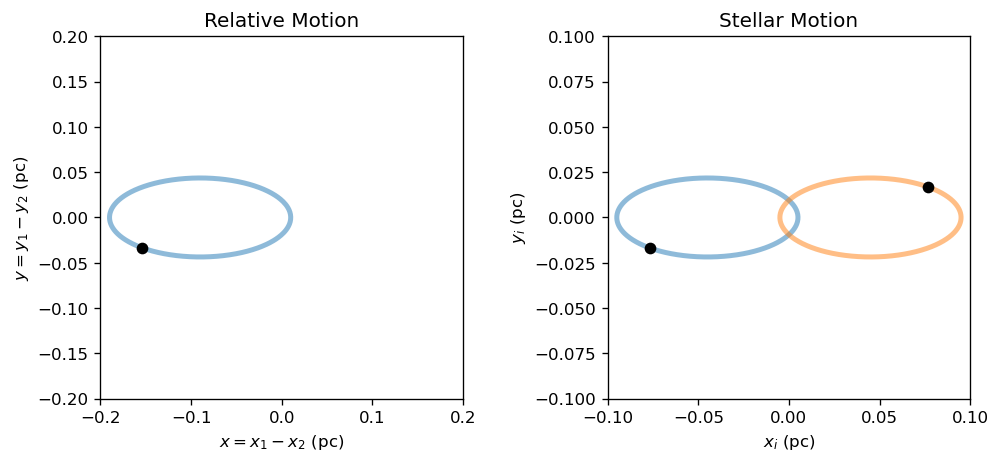

In [12]:
# r calculation needs to be done separately because the find_nearest_ command cannot be 
# vectorized; so it must be loaded

def r_(tau,a,e):
    if a == np.inf:
        return [np.inf,1]
    tau = np.modf(tau)[0]
    n_e_eff = find_nearest_(e_discrete,e)
    e_eff = e_discrete[n_e_eff]
    psi = psi_discrete[find_nearest_(tau_mat[:,n_e_eff], tau)]
    return [a * (1 - e * math.cos(psi)),psi]

## other masses
m_star = 0.5 # mass of each star 
mu = m_star / 2 # reduced mass
M = 2 * m_star # total mass
k = G * m_star * m_star # U(p) = -k/r

ai = 0.1
ei = 0.9

# invert t(psi, e) for fixed e to get psi(t,e)
# n_e_eff = np.searchsorted(e_discrete,e_sample,side="left")
taui = 3/4
tau_list = np.linspace(taui, taui+1,1000)
tau_list = np.modf(tau_list)[0]
r_psi_mat = np.array([r_(tau,ai,ei) for tau in tau_list])
r_list = r_psi_mat[:,0]
psi_list = r_psi_mat[:,1]

n_e_eff = find_nearest_(e_discrete,ei)
e_eff = e_discrete[n_e_eff]
cos_eta_list = (np.cos(psi_list) - e_eff)/(1 - e_eff * np.cos(psi_list))

def sin_eta(cos_eta,psi):
    eta = np.arccos(cos_eta)
    if psi <= np.pi:
        return np.sin(eta)
    else:
        return -np.sin(eta)
    
sin_eta_vec = np.vectorize(sin_eta)
sin_eta_list = sin_eta_vec(cos_eta_list,psi_list)
cos_eta_0 = cos_eta_list[0]
sin_eta_0 = sin_eta_list[0]

if sin_eta_0 >= 0:
    eta_0 = np.arccos(cos_eta_0)
else:
    eta_0 = -np.arccos(cos_eta_0) 

x_list = r_list * cos_eta_list
y_list = r_list * sin_eta_list

fig = plt.figure(figsize=(10,4), dpi= 120)
ax = fig.add_subplot(121, aspect = 'equal')
ax2 = fig.add_subplot(122, aspect = 'equal')
ax.plot(x_list,y_list, ls = '-', label='Unperturbed', alpha = 0.5, lw = 3)
ax.scatter(x_list[0],y_list[0],c='k', zorder = 100, label = '$\\mu$ or $m_{i}$')

ax.set_title('Relative Motion')
ax.set_xlabel('$x = x_{1} - x_{2}$ (pc)')
ax.set_ylabel('$y = y_{1} - y_{2}$ (pc)')
ax.set_xlim([-2*ai,2*ai])
ax.set_ylim([-2*ai,2*ai])

ax2.set_title('Stellar Motion')
ax2.plot(x_list/2,y_list/2, ls = '-',  alpha = 0.5, lw = 3)
ax2.plot(-x_list/2,-y_list/2, ls = '-',  alpha = 0.5, lw = 3)
ax2.scatter(x_list[0]/2,y_list[0]/2,c='k', zorder = 100)
ax2.scatter(-x_list[0]/2,-y_list[0]/2,c='k', zorder = 100)
ax2.set_xlabel('$x_{i}$ (pc)')
ax2.set_ylabel('$y_{i}$ (pc)')
ax2.set_xlim([-1*ai,1*ai])
ax2.set_ylim([-1*ai,1*ai])

## Resorting Encounter Parameters
We generated $N_{enc} = N \times K$ encounter parameters for $K$ binaries evolving for $N$ timesteps. These parameters were generated as one-dimensional arrays (vectors). We want transform these vectors into matrices, whose rows correspond to a specific binary and whose columns correspond to different timesteps. 

As an example, take the vector of impact parameters $\vec{p}$, containing $N_{enc}$ elements. The result of the transformation would be given as the matrix:
$$ 
\overleftrightarrow{p} = \left[\begin{array}{cccc}
p_{10} & p_{11} & \cdots & p_{1 N} \\
p_{20} & p_{21} & \cdots & p_{2 N} \\
\vdots & \vdots & \ddots & \vdots \\
p_{K 0} & p_{K 1} & \cdots & p_{K N}
\end{array}\right]. $$
Again, each row $i$ corresponds to the impact parameters of all encounters experienced by a single binary (ordered by timestep $j$) and each column $j$ gives to the impact parameters experienced by each binary at timestep $i$.

In [13]:
## reshape encounters to distribute encounters evenly over all K binaries
p_sample=p_sample.reshape(-1,N)
theta_sample=theta_sample.reshape(-1,N)
phi_sample=phi_sample.reshape(-1,N)
v_sample=v_sample.reshape(-1,N)
gamma_sample=gamma_sample.reshape(-1,N)
tau_rand=tau_rand.reshape(-1,N)

## Loading the Structure Function $U(p)$
As described in the paper, each encounters results in velocity kicks on each star given by 
$$ \begin{equation} \label{eq:impulse}
    \Delta \vec{v}_{i} = -\frac{2GM_{p}}{v_{p}} U(p_{i}) \frac{\vec{p_{i}}}{p_{i}^{2}},
\end{equation} $$
where the structure function $U(p)$ is given by
$$ \begin{equation} \label{eq:u}
    U(p) = \int_1^\infty d\xi \frac{\mu_{p} (p \xi)}{\xi^2 \sqrt{\xi^2-1}}.
\end{equation} $$
Here, $\mu_{p}(r)$ is the perturber's normalized enclosed mass $M_{p}(<r)/M_{p}$. This structure function encodes all the information we need regarding the perturber's density profile. As described in Sec. 3 of the notebook, we consider perturbers with power-law density profiles truncated at radius $R_{p}$:
$$ \rho(r;\alpha) \propto r^{\alpha} \ \Theta(R_{p} - r) \ : \ \alpha > -3. $$

In the supplementary pdf, we show the structure function corresponding to these perturbers is given by
$$ U^{\alpha}(p,R_p) = \frac{\sqrt{\xi^{2} - 1}}{\xi^{\alpha + 4}} \times \left. _{2}F_{1}\left (\frac{1}{2}, \frac{3 + \alpha}{2}, \frac{3}{2}, \frac{\sqrt{\xi^{2} -1}}{\xi^{2}} \right ) \right |_{\xi = R_p /p} + 1 - \sqrt{1 - \left ( \frac{p}{R_p} \right )^{2}}, $$
where $_2 F_1$ denotes the hypergeometric function.

In [14]:
## load functions relevant to binary evolution
# Analytical Definition of U(p) (Subject to calculational breaking down)
# See Appendix of Report for neater formulas

## binary period
def period_(a,k):
    return 2*np.pi*a**(3/2)*np.sqrt(1/k) * ( (km_m) / (pc_m) ) * ( (Gyr_yr) * (yr_s) ) # Gyr

def Ua_(p,R,alpha):
    if p < R:
        x = R*R/p/p
        x_inv = 1/x
        return ( 1 - (math.sqrt(-x_inv + 1)) + 
                (math.sqrt(-1 + x)*hyp2f1(0.5,(3 + alpha)/2.,1.5,1 - x_inv))/(x*x*(R/p)**alpha) )
    else:
        return 1

In [15]:
## Example: Plot Structure Function for Truncated Power-Law Density Profiles

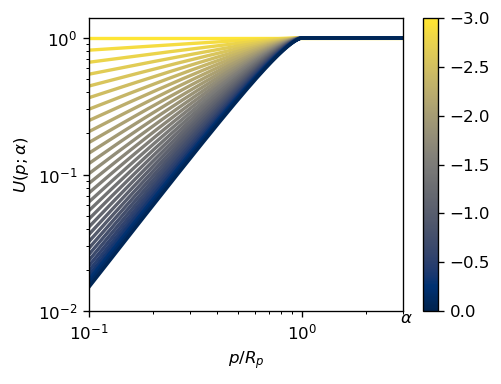

In [16]:
from scipy.special import hyp2f1

def U_arb_(p,R,alpha):
    if p < R:
        return ( 1 - (p*math.sqrt(-1 + R*R/p/p))/R + 
                (p*p*p*p*math.sqrt(-1 + R*R/p/p)*hyp2f1(0.5,(3 + alpha)/2.,1.5,1 - p*p/R/R))/(R*R*R*R*(R/p)**alpha) )
    else:
        return 1
    
U_arb_vec_ = np.vectorize(U_arb_) 
alpha_list = np.linspace(-3,0,30)
Na = len(alpha_list)

# -----

fig_u = plt.figure(figsize=(4,3), dpi= 120)
ax = fig_u.add_subplot(111)

rs = 100

# Set color gradient of plots
cmap = plt.get_cmap('cividis')

# Plot the data
color_code = 0.99
color = cmap(color_code)

rlist = np.logspace(-1,1,1000)
for alpha in alpha_list:
    if alpha == 2:
        ax.plot(rlist,U_arb_vec_(rlist*rs,rs,alpha), lw = 2, c=color, alpha = 1, label = 'Power Law')
        continue
        
    ax.plot(rlist,U_arb_vec_(rlist*rs,rs,alpha), lw = 2, c=color, alpha = 1)
    color_code -= 1/(Na); color = cmap(color_code)
        
ax.set_xlabel('$p/R_{p}$')
ax.set_ylabel('$U(p;\\alpha)$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(0.1,3)
ax.set_ylim(0.01,1.4)

# setup the normalization and the colormap
normalize = mpl.colors.Normalize(vmin=-3, vmax=0)
colormap = mpl.cm.cividis_r

# setup the colorbar
scalarmappaple = mpl.cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(np.flip(np.linspace(-3,0,30)))
cb = plt.colorbar(scalarmappaple)
cb.ax.invert_yaxis()
cb.ax.set_ylabel('$\\alpha$', rotation = 0, labelpad = -50, y = 0)

fig_u.tight_layout(pad = 0)

fig_u.savefig('fig-u-v0.6.pdf', format = 'pdf', bbox_inches='tight')

## Binary Evolution
### Unperturbed Binary Evolution
We now load functions that evolve binaries during an encounter. The first function allows us to retrieve the separation $r$ given values for $\tau$ (related to $\psi$), $a$, and $e$ according to the equation:
$$ r = a(1 - e \cos \psi). $$
First, we convert $\tau$ to $\psi$ by inverting the Kepler Equation using the method introduced in Sec. 5. Then, we calculate the physical separation $r$. Note, the function used to perform this calculation also saves the value of $\psi$.

### Perturbed Binary Evolution
Things are a bit technical here. A simple discussion is in the paper. For a more in-depth discussion, we recommend readers read the supplementary material and the comments in the function's definition. The way we wrote the code is computationally efficient, but harder to read. Long story short, given pre-encounter orbital state parameters $(a_i, e_i, \psi_i, M)$, encounter parameters $(p,\theta,\phi,\gamma,v_p)$, and perturber density parameters $(M_p, R_p, \alpha)$, we generate post-encounter orbital state parameters $(a_f, e_f, \psi_f, M)$.

In [17]:
# r calculation needs to be done separately because the find_nearest_ command cannot be 
# vectorized; so it must be loaded

def r_(tau,a,e):
    if a == np.inf:
        return [np.inf,1]
    tau = np.modf(tau)[0]
    n_e_eff = find_nearest_(e_discrete,e)
    e_eff = e_discrete[n_e_eff]
    psi = psi_discrete[find_nearest_(tau_mat[:,n_e_eff], tau)]
    return [a * (1 - e * math.cos(psi)),psi]

# need to calculate these using a for loop to produce r_sample

def orbital_parameters_(ai,ei,r,psi,k,p,theta,phi,gamma,vp,Mp,rs,alpha):
    if ai == np.inf or ei >= 1:
        return np.array([np.inf,ei,-1])
    
    sin_theta = math.sin(theta)
    cos_theta = math.cos(theta)
    cos_2_theta = math.cos(2*theta)
    sin_phi = math.sin(phi)
    cos_phi = math.cos(phi)
    sin_gamma = math.sin(gamma)
    cos_gamma = math.cos(gamma)
    
    # velocity calculation 
    li = np.sqrt(k * ai * (1.-ei*ei) )
    eta_dot = li / r / r

    Ei = k/2/ai
    if psi <= np.pi:
        r_dot = math.sqrt(np.abs(2 * (-Ei + k/r - r*r*eta_dot*eta_dot/2)))
    else:
        r_dot = -math.sqrt(np.abs(2 * (-Ei + k/r - r*r*eta_dot*eta_dot/2)))
        
    v_x = r_dot * sin_theta * cos_phi + r * eta_dot * (- cos_theta * cos_phi * sin_gamma - sin_phi * cos_gamma)
    v_y = r_dot * sin_theta * sin_phi + r * eta_dot * (- cos_theta * sin_phi * sin_gamma + cos_phi * cos_gamma)
    v_z = r_dot * cos_theta + r * eta_dot * sin_gamma*sin_theta
    
    # delta_E calculation
    delta_v_factor = 2*G*Mp/vp
    
    a = r/2
    rho1_sq = p*p+a*a*(1-cos_2_theta)/2+2*a*p*sin_theta*cos_phi
    rho2_sq = p*p+a*a*(1-cos_2_theta)/2-2*a*p*sin_theta*cos_phi
    U1 = Ua_(math.sqrt(rho1_sq),rs,alpha)
    U2 = Ua_(math.sqrt(rho2_sq),rs,alpha)
    U1_rho1_sq = U1/rho1_sq
    U2_rho2_sq = U2/rho2_sq
    delta_v_eff_sq = U1*U1_rho1_sq+U2*U2_rho2_sq-U1_rho1_sq*U2_rho2_sq*(2*p*p-a*a*(1-cos_2_theta))
    
    r2_proj_xy = a * sin_theta
    r2_proj_x = r2_proj_xy * cos_phi
    r2_proj_y = r2_proj_xy * sin_phi
    
    delta_v_eff_x = - U1_rho1_sq * (p + r2_proj_x) + U2_rho2_sq * (p - r2_proj_x)
    delta_v_eff_y = - U1_rho1_sq * r2_proj_y - U2_rho2_sq * r2_proj_y
    v_dot_delta_v_eff = v_x * delta_v_eff_x + v_y * delta_v_eff_y
    
    delta_E = delta_v_factor * ( delta_v_factor * delta_v_eff_sq / 2 + v_dot_delta_v_eff )

    # delta_l calculation
    delta_l_x = delta_v_factor * r * r2_proj_y * cos_theta * (U1_rho1_sq + U2_rho2_sq)
    delta_l_y = delta_v_factor * r * cos_theta * (p * (U2_rho2_sq - U1_rho1_sq) - r2_proj_x * (U1_rho1_sq + U2_rho2_sq) )
    delta_l_z = delta_v_factor * 2 * p * r2_proj_y * (U1_rho1_sq - U2_rho2_sq)
    
    # semimajor axis calculation
    Ef = Ei-delta_E
    if Ef>0:
        af = k/2/Ef
    else:
        return np.array([np.inf,ei,-1])
    
    # eccentricity calculation
    li_x = li * (-cos_theta * cos_phi * cos_gamma + sin_phi * sin_gamma)
    li_y = li * (-cos_theta * sin_phi * cos_gamma - cos_phi * sin_gamma)
    li_z = li * cos_gamma * sin_theta
    lf = math.sqrt((delta_l_x + li_x)*(delta_l_x + li_x) + (delta_l_y + li_y)*(delta_l_y + li_y) +
                 (delta_l_z + li_z)*(delta_l_z + li_z))
    ef = math.sqrt(1-lf*lf/k/af)
    if ef >= 1:
        return np.array([np.inf,ei,-1])
    
    # new initial time calculation
    vf_x = v_x + delta_v_factor * delta_v_eff_x
    vf_y = v_y + delta_v_factor * delta_v_eff_y
    vf_z = v_z
    vf_r = vf_x * sin_theta * cos_phi + vf_y * sin_theta * sin_phi + vf_z * cos_theta
    cos_psif = (1 - (1 - ei * math.cos(psi)) * ai/af) / ef
    if abs(cos_psif) > 1:
        cos_psif = cos_psif / abs(cos_psif)
    if vf_r >= 0:
        psif = math.acos(cos_psif)
    else:
        psif = - math.acos(cos_psif)  + 2 * math.pi
    tauf = (psif - ef * math.sin(psif)) / 2 / math.pi
    
    return np.array([af,ef,tauf],dtype=np.float64)

### Example: Perturber-Binary Encounter



NameError: name 'p' is not defined

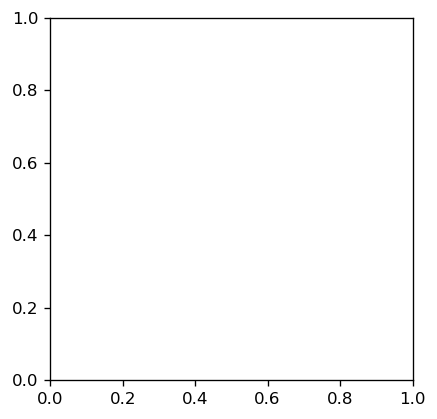

In [18]:
# perturber position (valid for only perpendicular encounter)
fig = plt.figure(figsize=(4,4), dpi= 120)
ax = fig.add_subplot(111, aspect = 'equal')

x_p = cos_eta_0 * p
y_p = sin_eta_0 * p
ax.scatter(0, 0,c=cmap(0.99), zorder = 100, marker=r'$.$', s = 50, label = 'Perturber')
cir = plt.Circle((0, 0), rs, color=cmap(0.99),fill=True, alpha = 0.25)
ax.add_patch(cir)


x1_list_0_translated_rotated = x1_list_0_translated * np.cos(eta_0) + y1_list_0_translated * np.sin(eta_0)
y1_list_0_translated_rotated =  - x1_list_0_translated * np.sin(eta_0) + y1_list_0_translated * np.cos(eta_0)

x2_list_0_translated_rotated = x2_list_0_translated * np.cos(eta_0) + y2_list_0_translated * np.sin(eta_0)
y2_list_0_translated_rotated =  - x2_list_0_translated * np.sin(eta_0) + y2_list_0_translated * np.cos(eta_0)

ax.plot(x1_list_0_translated_rotated,y1_list_0_translated_rotated, ls = '-', color = cmap(0),  alpha = 0.5, lw = 3)
ax.plot(x2_list_0_translated_rotated,y2_list_0_translated_rotated, ls = '-', color = cmap(0),  alpha = 0.5, lw = 3)

x1_list_translated_rotated = x1_list_translated * np.cos(eta_0) + y1_list_translated * np.sin(eta_0)
y1_list_translated_rotated =  - x1_list_translated * np.sin(eta_0) + y1_list_translated * np.cos(eta_0)

x2_list_translated_rotated = x2_list_translated * np.cos(eta_0) + y2_list_translated * np.sin(eta_0)
y2_list_translated_rotated =  - x2_list_translated * np.sin(eta_0) + y2_list_translated * np.cos(eta_0)

ax.plot(x1_list_translated_rotated,y1_list_translated_rotated, ls = '-', color = cmap(0.7), alpha = 0.7, lw = 3)
ax.plot(x2_list_translated_rotated,y2_list_translated_rotated, ls = '-', color = cmap(0.7), alpha = 0.7, lw = 3)
ax.scatter(x1_list_translated_rotated[0],y1_list_translated_rotated[0],c='k', zorder = 100, label = 'Star')
ax.scatter(x2_list_translated_rotated[0],y2_list_translated_rotated[0],c='k', zorder = 100)

vi_x_rot = vi_x * np.cos(eta_0) + vi_y * np.sin(eta_0)
vi_y_rot = - vi_x * np.sin(eta_0) + vi_y * np.cos(eta_0)
vf_x_rot = vf_x * np.cos(eta_0) + vf_y * np.sin(eta_0)
vf_y_rot = - vf_x * np.sin(eta_0) + vf_y * np.cos(eta_0)

vectors = np.array([[vi_x_rot/2,vi_y_rot/2],[vf_x_rot/2,vf_y_rot/2],[-vi_x_rot/2,-vi_y_rot/2],[-vf_x_rot/2,-vf_y_rot/2]])
origin = np.array([[x1_list_translated_rotated[0],x1_list_translated_rotated[0],x2_list_translated_rotated[0],x2_list_translated_rotated[0]],[y1_list_translated_rotated[0],y1_list_translated_rotated[0],y2_list_translated_rotated[0],y2_list_translated_rotated[0]]])
ax.quiver(*origin, vectors[:,0], vectors[:,1], scale = 0.5, color = [cmap(0.2),cmap(0.85)], zorder = 100, linewidth = 0.1)

ax.set_xlabel('$x$ (pc)')
ax.set_ylabel('$y$ (pc)')
ax.set_xlim([-0.0025,3*ai])
ax.set_ylim([-1.1*ai,1.1*ai])
#ax2.grid()
#ax.set_xticks(np.linspace(-2*ai,2*ai,5))
#ax.set_yticks(np.linspace(-2*ai,2*ai,5))
ax.tick_params(direction='out', colors='k',
               grid_color='k', grid_alpha=0.25)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

#ax2.grid()
ax.tick_params(direction='out', colors='k',
               grid_color='k', grid_alpha=0.25, labelsize = 22)

print(ai)
print(Mp)

# Scattering Matrix Calculation
We have everything we need to calculate the scattering matrix. Recall, it allows us to evolve initial distributions $\phi_0(\vec{q_0})$ to present-day distributions $\phi(\vec{q})$ via 
$$
\begin{aligned}
    \phi(\vec{q}) = \int d\vec{q}_0 \ S(\vec{q}|\vec{q}_0) \ \phi_0(\vec{q}_0).
\end{aligned}
$$

Looking at the equation above, we can simulate the evolution of a large number of binaries with orbital states sampled from $\phi_{0}(\vec{q}_{0})$ to calculate $\phi(\vec{q})$ directly. How we run the simulations can be understood in terms of the definition of the scattering matrix:
$$  
\begin{aligned}
    S(\vec{q}|\vec{q}_0) = \int\prod_{i=0}^{N-1}\left [ \ d\vec{q}_i \ f_{i}(\vec{q}_{i+1} |\vec{q}_i)\right ],
\end{aligned}
$$
where $i$ here denotes each timestep and $f_{i}$ denotes the probability of an encounter evolving $\vec{q}_i$ to $\vec{q}_{i+1}$ (including the change in the eccentric anomaly $\psi_{i}$ due to orbital evolution between the timestep $i$ and timestep $i+1$). That is for all the binaries, we randomly generate encounters for each of them and evolve them for $T = 10$ Gyr ($N$ timesteps).

However, as discussed in Section III, the initial semimajor axis distribution is not well-understood, so we wish to marginalize over the possible distributions for our constraints to be independent of the semimajor axis distribution. It would be very inefficient to run simulations for each possible initial semimajor axis distribution, so we follow a technique introduced by Yoo et al. As we specify the distributions in $(e,\psi,M)$, let's integrate over these parameters to write the above equation as
$$
\begin{aligned}
    \phi(\vec{q}) = \int d\vec{a}_0 \ S(\vec{q}|a_0) \ \phi_0(a_{0}),
\end{aligned}
$$
where $S(\vec{q}|a_0)$ is now the scattering matrix integrated over $(e,\psi,M)$. This equation suggests that, if we can specify the scattering matrix over a range of initial semimajor axes $a_{0}$, then we need only convolve it with the initial semimajor axis distribution $\phi_{0}(a_{0})$ to calculate $\phi(\vec{q})$. Therefore, instead of performing a set of simulations for all the initial semimajor axis distributions, we can simulate binaries with semimajor axes $a_{0}$ to estimate $S(\vec{q}|a_0)$ (and sampled from the distributions in $(e,\psi,M)$. To evolve any initial distribution of binaries, we simply perform the integral above. In practice, we estimate $S(\vec{q}|a_0)$ over bins of $a_{0}$, which we discuss in Sec. 10.1.

Lastly, for our work, we only care about the present-day distribution of projected separations $s$. So, our object of interest is the scattering matrix $S(s|a_{0})$, which is obtained by projecting down $\vec{q} \rightarrow s$. I.e., 
$$
\begin{equation}
    S(s|a_0) = \int d\cos i \int d\vec{q} \ \delta(s-r\cos i) \ S(\vec{q}|a_0),
\end{equation}
$$
where $i$ denotes the binary's inclination angle.
This allows us to compute the evolved separation distribution via
$$ 
\begin{aligned}
    \phi(s) = \int da_0 \ S(s|a_0) \ \phi_0(a_0).
\end{aligned}
$$
Therefore, the final result of our simulations is $S(s|a_0)$.

## Sample Initial Binary Orbital State Parameters
In our code, we estimate the scattering matrix $S(s|a_0)$ using the histogram $S(s_i|a_j)$, describing the probability that a binary with initial semimajor axis in a bin centered at $a_j$ (and orbital state parameters $(e,\psi,M)$ sampled from their respective distributions) has projected separation in a bin centered at $s_{i}$ relative to Earth after interacting with a population of perturbers for $T=10$ Gyr. We choose our bins in initial semimajor axis and measured separation to be equally-spaced in logarithmic space. For reasons discussed in stats/limits.ipynb, where we set limits on subhalo populations, we save the scattering matrix at each timestep. 
### Initial Semimajor Axis $a_{0}$ 
In this code, we generate binaries with semimajor axes sampled uniformly across 175 bins logarithmically spaced between $a_{0} = 10^{-5}$ pc and $a_{0} = 10^2$ pc (This range is larger than the $10^{-4}-10^0$ pc range of the wide binary catalog, to allow for binaries migrating into the region of interest as a result of tidal encounters). Each bin contains $K$ binaries. In addition to allowing us to estimate the scattering matrix, this makes segments of the scattering matrix to be performed in parallel. That is, each simulation evolves binaries with initial semimajor axis sampled from a single one of these bins, say the one centered at $a_{j}$. This would specify the approximate scattering matrix corresponding to this $a_j$. Therefore, the full scattering matrix for all initial semimajor axis values requires 175 simulations to include all bins. 
### The Rest of the Orbital State Parameters
1. Thermal Eccentricity Distribution:
$$ \phi_{0}(e_0) = 2e_0 $$
$$ \rightarrow E_{0} = \sqrt{U([0,1)]},$$
where $E_{0}$ is the random variable corresponding to initial eccentricity $e_0$.
2. Eccentric Anomaly Distribution: 
$$ \begin{equation}
    \phi_{0}(\psi_0| e_0) = 1 - e_0 \cos \psi_0.
\end{equation} $$, 
corresponding to a uniform distribution of dynamical times $t$, or rather,
$$ \phi_0(\tau_0) = 1$$
$$ \rightarrow \mathcal{T}_{0} = U([0,1)]$$
We already sampled this when we sampled the encounter parameters. They correspond to the row $i = 0$ in the matrix of $\tau$-values.

3. Mass Distribution: We sample the distribution of binary masses $M$ from the observed distribution of masses. 

4. Binary Inclination Angles:
We assume binaries are uniformly distributed in $d\cos i$, as the orientation of the binaries is uncorrelated with their line-of-sight to Earth.

In [19]:
## bin construction
bin_scale = 'log'

log_alow = float(-5)
str_log_alow = str.format('{0:.3f}',log_alow)
log_ahigh = float(2)
str_log_ahigh = str.format('{0:.3f}',log_ahigh)
step_size = float(0.04) # number of bins
str_step_size = str(step_size)
#str_step_size = str.format('{0:.3f}',step_size)

log_alow_offset = float(0)
str_log_alow_offset = str.format('{0:.3f}',log_alow_offset)
log_ahigh_offset = float(0)
str_log_ahigh_offset = str.format('{0:.3f}',log_ahigh_offset)

## preload evolved projected separation array
#s_sample = np.zeros((p_sample.shape[0],p_sample.shape[1]+1))

# make the array of semimajor axis values
if bin_scale=='log': 
    #log_bins_hist = np.arange(log_alow,log_ahigh,step_size)
    #bins_hist = 10**log_bins_hist
    
    bins_finite = np.arange(log_alow,log_ahigh+step_size,step_size)  # bins
    bins_finite = 10**bins_finite
    bins_hist = np.arange(log_alow+log_alow_offset,log_ahigh+log_ahigh_offset+step_size,step_size)
    bins_hist = 10**bins_hist

if bin_scale=='lin':
    alow_offset=10**(log_alow)
    ahigh_offset=10**(log_ahigh)
    
    #alow=10**log_alow
    #ahigh=10**log_ahigh
    
    Nbins = 180
    bins_finite = np.linspace(alow_offset,ahigh_offset,Nbins)
    #bins_hist = np.linspace(alow,ahigh,Nbins)  # bins

# generate initial binary semimajor axis values
### a_init = a0*np.ones(p_sample.shape[0]) # initial semimajor axis values
log_bins_finite = np.arange(log_alow,log_ahigh+step_size,step_size)
n_a0_low = np.where(log_bins_finite <= np.log10(a0))[0][-1]

log_bin_min = log_bins_finite[n_a0_low]
log_bin_max = log_bins_finite[n_a0_low + 1]
log_a_init = log_bin_min * np.ones(p_sample.shape[0]) + (log_bin_max - log_bin_min) * np.random.random(p_sample.shape[0])# initial semimajor axis values

# generate other initial orbital parameters
a_sample = 10**log_a_init
e_sample = np.sqrt(np.random.random(p_sample.shape[0]))
#q_sample = np.load('q_data.npy', allow_pickle = True) [Evolution independent of q]
M_data = np.load('M_data' + '.npy', allow_pickle = True)
rand_ind = np.random.randint(0, high=4350, size=K, dtype=int)
M_sample = np.array([M_data[n] for n in rand_ind])
#M_sample = np.ones(K)
#mu_sample = q / (1 + q)**2 * M
k_sample = G * M_sample # U(p) = -k/r

# generate orientations of binaries relative to line of sight 
## we generate these only once since different timesteps will correspond to different perturber fractions "f"
i_sample = np.arccos(2 * ( np.random.random(size = K) ) - np.ones(K))

## Save the Initial Separation Distribution

In [20]:
## evolve binaries
### initial timestep [performed to columns of histogram counts and errors]
timestep = 0
tau_sample_obs = tau_rand[:,timestep]

### Obtain physical separation given orbital parameters
r_psi_mat = np.array([r_(tau_sample_obs[n],a_sample[n],e_sample[n]) for n in range(K)])
r_sample = r_psi_mat[:,0]
psi_sample = r_psi_mat[:,1]

### Calculate the histogram of projected separations
s_sample = r_sample * np.sin(i_sample)

n, bins = np.histogram(s_sample, 
                      np.concatenate((bins_hist, [np.PINF])), range = [0,1], density = False) # histogram of binary seps
p_mat = n / np.diff(bins) / K  # density=True
p_err_mat = np.sqrt(n) / np.diff(bins) / K #error in density estimation (assume large counts)
binary_loss_fraction_list = [ n[-1] / K ]
binary_loss_fraction_err_list = [ np.sqrt(n[-1]) / K ] 

## Apply the First Encounter to all Binaries

In [21]:
### First encounter
orbital_parameters = np.array([orbital_parameters_(a_sample[n],e_sample[n],r_sample[n],psi_sample[n],
                                                   k_sample[n],
                                                   p_sample[n,timestep],theta_sample[n,timestep],
                                                   phi_sample[n,timestep],gamma_sample[n,timestep],v_sample[n,timestep],m,rs,alpha) 
                               for n in range(K)])
a_sample = orbital_parameters[:,0]
e_sample = orbital_parameters[:,1]
tau_sample = orbital_parameters[:,2]  

## Rest of Evolution
1. Record "Observed" Projected Separation at some Random Observation Time
2. Evolve Binary to next Timestep
3. Apply an Encounter to Binary
4. Repeat Step 1 up to final timestep $N$

In [22]:
for timestep in range(1,p_sample.shape[1]):
    ### observation time occurs at random time in between encounter
    tau_sample_obs = tau_sample + tau_rand[:,timestep] * delta_t / period_(a_sample, k_sample)
    
    ### Obtain physical separation given orbital parameters
    r_psi_mat = np.array([r_(tau_sample_obs[n],a_sample[n],e_sample[n]) for n in range(K)])
    r_sample = r_psi_mat[:,0]
    
    ### Calculate the histogram of projected separations
    s_sample = r_sample * np.sin(i_sample)
    
    ### save histogram
    n, bins = np.histogram(s_sample, 
                          np.concatenate((bins_hist, [np.PINF])), range = [0,1], density = False)
    p = n / np.diff(bins) / K
    p_err = np.sqrt(n) / np.diff(bins) / K
    
    p_mat = np.column_stack([p_mat, p])
    p_err_mat = np.column_stack([p_err_mat, p_err])
    binary_loss_fraction_list.append(n[-1] / K)
    binary_loss_fraction_err_list.append(np.sqrt(n[-1]) / K)
    
    #### evolve to next timestep
    tau_sample = tau_sample + delta_t / period_(a_sample, k_sample)

    ### Obtain physical separation given orbital parameters
    r_psi_mat = np.array([r_(tau_sample[n],a_sample[n],e_sample[n]) for n in range(K)])
    r_sample = r_psi_mat[:,0]
    psi_sample = r_psi_mat[:,1]
    
    #### Perturber effect on binary
    orbital_parameters = np.array([orbital_parameters_(a_sample[n],e_sample[n],r_sample[n],psi_sample[n],
                                                       k_sample[n],
                                                       p_sample[n,timestep],theta_sample[n,timestep],
                                                   phi_sample[n,timestep],gamma_sample[n,timestep],v_sample[n,timestep],m,rs,alpha) 
                               for n in range(K)])
    a_sample = orbital_parameters[:,0]
    e_sample = orbital_parameters[:,1]
    tau_sample = orbital_parameters[:,2]                    

## Save Data
All that we really need from here is the *results_hist* data. But, we save the data as a larger list containing more data.

In [23]:
results_hist = [p_mat,bins,p_err_mat,
                binary_loss_fraction_list,binary_loss_fraction_err_list]
input_vec = [a0,log_m,log_rs,alpha,log_K]
#input_vec = [a0,log_m,log_rs,alpha,log_N_enc_approx]
fixed_parameter_vec = [f,v0,T]
numbers_vec = [N, K, N_enc]
results = [input_vec, results_hist, fixed_parameter_vec,numbers_vec]

filename = 'hists_' + str_a0
np.save(filename, results)

tf = timeit.default_timer()
print('Run Time (min): ' + str( (tf - ti) / 60 ) )

Run Time (min): 1.04380523931668


/home/edr/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


/tmp/ipykernel_503/2400334824.py:34: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim([np.min(p_final),np.max(p_final)])


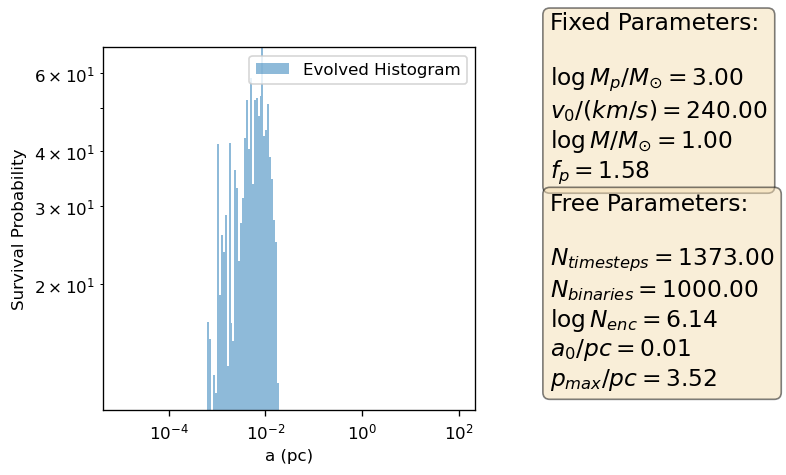

In [27]:
# plot evolved distribution from the stored simulation data

if bin_scale=='log': 
    bins_finite = np.arange(log_alow,log_ahigh+step_size,step_size)  # bins
    bins_finite = 10**bins_finite
    mid = 0.5 * (bins_finite[1:] + bins_finite[:-1])
    
    bins_hist = np.arange(log_alow+log_alow_offset,log_ahigh+log_ahigh_offset+step_size,step_size)
    bins_hist = 10**bins_hist
    mid_hist = 0.5 * (bins_hist[1:] + bins_hist[:-1])
    
if bin_scale=='lin':
    alow=10**log_alow
    ahigh=10**log_ahigh
    
    bins_finite = np.linspace(alow,ahigh,Nbins)  # bins
    mid = 0.5 * (bins_finite[1:] + bins_finite[:-1])

timestep = -1 # present-day
p_final = np.array([results[1][0][j,timestep] for j in range(len(mid))]) # survival probability 
sigma_final = np.array([results[1][2][j,timestep] for j in range(len(mid))])    # error of survivial prob

fig = plt.figure(figsize=(4, 4), dpi= 120)
ax = fig.add_subplot(111)

ax.bar(mid,p_final,width=np.diff(bins[:-1]),alpha=0.5, label = 'Evolved Histogram')
#ax.errorbar(mid, p_final, sigma_final, c = 'r', fmt = 'none')

ax.set_xlabel('a (pc)')
ax.set_ylabel('Survival Probability')
if bin_scale == 'log': ax.set_xscale('log')
if bin_scale == 'lin': ax.set_xscale('linear')
ax.set_yscale('log')
ax.set_ylim([np.min(p_final),np.max(p_final)])

textstr1 = '\n'.join((
    r'Fixed Parameters:',
    r' ',
    r'$\log M_p/M_{\odot}=%.2f$' % (np.log10(m), ),
    r'$v_{0}/(km/s)=%.2f$' % (v0, ),
    r'$\log M/M_{\odot}=%.2f$' % (M, ),
    r'$f_p=%.2f$' % (f, ) 
))

textstr2 = '\n'.join((
    r'Free Parameters:',
    r' ',
    r'$N_{timesteps}=%.2f$' % (N, ),
    r'$N_{binaries}=%.2f$' % (K, ),
    r'$\log N_{enc}=%.2f$' % (np.log10(N_enc), ),
    r'$a_{0}/pc=%.2f$' % (a0, ),
    r'$p_{max}/pc=%.2f$' %(R, ),
#    r'$Binary \ Loss \ Fraction=%.2f$' % (len(np.where(a_final_array>1)[0]) / K, )
))

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(1.2, 1.1, textstr1, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax.text(1.2, 0.6, textstr2, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax.legend()

# Sorting the Data
After running these simulations for all bins of initial semimajor axes, we sort them so we can contain the scattering matrix into one object. Though we don't perform the sorting here, we describe the *evol_sorter.npy* file, used to sort these histograms into a complete scattering matrix. 

Denote the *numpy* array for all simulations as $res(a)$ For each perturber mass, we sort the files in ascending order of $a$ and form a correspondence of initial semimajor axis values and the results stored for each value by storing the data as the list
$$ \{[a,res(a)]\}_{a} $$
Ordering the results in this way makes it easy to load results. For instance, it makes it easy to sum/plot results due to the order.

# Evolving a Distribution of Binaries using the Scattering Matrix
Below, we load the scattering matrix obtained using simulations with $K = 10^{4}$ binaries to evolve an initially logarithmically-flat distribution of binaries. For this special case, the number of binaries per bin is given by
$$ 
N(s_{i}) = \sum_{j} \Delta a_{j} \ S(s_{i}|a_{j}) \ N_{0}(a_{j}),
$$

In [51]:
# NOTE: need to unzip compressed file in the "dmbinaries/statistics/sorted_data" file for this to work

n_list = []
err_list = []

## parameters
log_K = float(4)  # v0.3: number of binaries fixed
str_log_K = str.format('{0:.2f}',log_K)
K = int(10**log_K)  

## Load energy injection rate data
local_dir = '../statistics/'
sorted_dir = local_dir + 'sorted_data/' +str_log_m+'_'+str_log_rs+'_'+str_alpha+'_'+str_log_f+'_'+str_log_eps+'_'+str_log_K
file_name = 'hists_'+str_log_m+'_'+str_log_rs+'_'+str_alpha+'_'+str_log_f+'_'+str_log_eps+'_'+str_log_K+'_'+bin_scale+'_'+str_log_alow+'_'+str_log_ahigh+'_'+str_step_size+'_'+str_log_alow_offset+'_'+str_log_ahigh_offset

results_list = np.load(os.path.join(sorted_dir, file_name + '.npy'), allow_pickle = True)

# evolve histogram for specified timestep
timestep = -1

l = 0
    
bins = bins_finite     # initial histogram of binaries
dnda = []                       # evolved histogram counts
dnda_err = []                   # evolved histogram count errors
for i in range(len(mid_hist)): 
    a0 = mid_hist[i]
    p_i = np.array([results_list[j][1][1][0][i,timestep]*np.diff(bins_hist)[i]*K for j in range(len(mid))])        # survival probability 
    sigma_i = np.array([results_list[j][1][1][2][i,timestep]*np.diff(bins_hist)[i]*K   for j in range(len(mid))])   # error of survivial prob

    dnda.append(np.sum(p_i))
    dnda_err.append(np.linalg.norm(sigma_i))

n_list.append(dnda)
err_list.append(dnda_err)
# ---


(10, 12000)

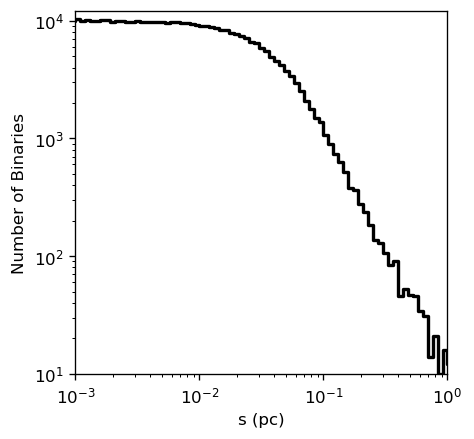

In [52]:
fig = plt.figure(figsize=(4, 4), dpi= 120)
ax = fig.add_subplot(111)
    
ax.step(mid_hist,n_list[0],alpha=1, c = 'k', lw = 2, where = 'mid')

ax.set_xlabel('s (pc)')
ax.set_ylabel('Number of Binaries')
if bin_scale == 'log': ax.set_xscale('log')
if bin_scale == 'lin': ax.set_xscale('linear')
ax.set_yscale('log')

ax.set_xlim([10**-3,1])
ax.set_ylim([10,12000])

# Summary of Algorithm
Each binary is simulated using an iterative algorithm. Suppose the simulation begins at $t_{0}$ and the encounter timesteps are given by $t_{1} \leq t_{2} \leq \ldots \leq t_{N}$, where $t_{n+1} = t_{n} + \delta t$ for $n = 0,\ldots,N-1$. At time $t_{n}$, the orbital parameters of a binary are given by $(a_{n},e_{n},\psi_{n})$. The orbital phase $\psi_{n}$ specifies the effective orbital time $\tau_{n}$ necessary for evolving the binary forward in time. We first generate the observed separations of binaries after $n$ encounters by calculating the projected physical separation of the binary at some random time between $t_{n}$ and $t_{n+1}$. The effective orbital time corresponding to observation is given by $\tau_{n} + U[0,1] \ \frac{\delta t}{P(a_{n})}$. We use this in Equations (\ref{eq:r}, \ref{eq:time}) to calculate the orbital phase and physical separation at the observation time. The projected physical separation is calculated using $s = r \sin (i)$, where $i$ is the random inclination assigned to the binary. These separations are saved as a histogram of binary projected separations that can be converted to the scattering matrix $S(s|a', t_{i})$. Following this observation step, we evolve the binary to the next encounter time $t_{n+1}$ as in the observation step to obtain an orbital phase and physical separation during the encounter. We calculate the effect of the encounter on binary orbital parameters using Equation (\ref{eq:impulse}) to calculate the impulse from the encounter parameters and Equations (\ref{eq:E_impulse}, \ref{eq:l_impulse}, \ref{eq:e_p} - \ref{eq:psi_p}) to translate the impulse to evolved orbital parameters $(a_{n+1}, e_{n}, \psi_{n})$. This procedure is repeated for $N$ times. At the final timestep, a final set of observed separations is stored as a histogram for the PDF $p(s | a', T)$. The entire binary evolution algorithm is described in Box \ref{box:steps}. 

\begin{mybox}[colback=white]{Binary Evolution Algorithm} \label{box:steps}
Initialization
\begin{enumerate}
    \item Load binary population uniformly from bin centered at $a'$
    \item Load perturber population
    \item Load encounter timesteps
    \item Generate encounter parameters corresponding to all binaries and timesteps
    \item Load effective orbital time matrix used for unperturbed binary evolution
\end{enumerate}

Evolve binaries from $t_{k}$ to $t_{k+1}$ for $k = 0,1,\ldots,N-1$. 
For each binary,
\begin{enumerate}
    \item Convert $\psi_{k} \rightarrow \bar{\tau}_{k}$
    \item Calculate and store binary projected physical separation corresponding to timestep $t_{k} = k \ \delta t$ where $\bar{\tau}_{obs} = \bar{\tau}_{k} + U[0,1] \ \frac{\delta t}{P(a_{k})} \mod 1$
    \item Load encounter parameters $\vec{x}_{k}=(p_{k},\theta_{k},\phi_{k},\gamma_{k},v_{p},_{k})$
    \item Evolve the pre-encounter binary orbital parameters to post-encounter orbital parameters:
        $$(a_{k},e_{k},\psi_{k}) \overset{(\ref{eq:impulse} - \ref{eq:l_impulse}), (\ref{eq:e_p}) - \ref{eq:psi_p})}{\longrightarrow} (a_{k+1},e_{k+1},\psi_{k+1})$$ 
    \item Repeat the loop up to the final timestep $N$
\end{enumerate}

Store final set of projected separations observed after the $Nth$ encounter